In [208]:
import numpy as np
import os
import scipy.stats as stats
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
#set seaborn as default for plots
sns.set_theme()

OUTPUT_FOLDER="output"
#  we now count the different stimuli in main task
SUBJECT_ID_FILE = os.path.join(OUTPUT_FOLDER, "subject_id_list.txt")
RAW_DUMP_FOLDER=os.path.join(OUTPUT_FOLDER, "raw_dump")
PLOTS_FOLDER=os.path.join(OUTPUT_FOLDER, "plots")

f=open(SUBJECT_ID_FILE, "r", encoding="utf-8")
subject_file_lines = f.readlines()
f.close()

subject_IDs = [int(line.split(" ")[0]) for line in subject_file_lines]
subject_names = [line.split(" ")[1] for line in subject_file_lines]
subject_status = [int(line.split(" ")[2]) for line in subject_file_lines]
good_subjects=[subject_IDs[i] for i in range(len(subject_IDs)) if subject_status[i]==1]



In [209]:
shuffle_d=np.zeros(shape=(len(good_subjects), 2))
set_size_d=np.zeros(shape=(len(good_subjects)+1, 4))
set_size_b=np.zeros(shape=(len(good_subjects)+1, 4))
HR_FAR_D_recall=np.zeros(shape=(len(good_subjects)+1, 3, 4 ))
def d_prime_criterea(Hit_rate,False_alarm_rate):
    F=stats.norm.ppf(False_alarm_rate)
    H=stats.norm.ppf(Hit_rate)
    criterion=-F
    d_prime=np.abs(H-F)
    bias=-(F+H)/2
    return d_prime,criterion,bias

def block_HR_FAR(results):
    total_hits=np.sum(results[:,0])
    total_misses=np.sum(results[:,1])
    total_false_alarms=np.sum(results[:,2])
    total_correct_rejections=np.sum(results[:,3])
    return total_hits/(total_hits+total_misses),total_false_alarms/(total_false_alarms+total_correct_rejections)

def plt_dprime(d_c_b,n_item,subject,name,xlbel):
    for n in range(len(n_item)):
        n_item[n]=round(n_item[n],2)
    fig,ax=plt.subplots(1,3,figsize=(7.5,2.5))
    ax[0].plot(n_item, d_c_b[:,0], 'o-')

    ax[0].set_ylabel('d_prime')
    ax[1].plot(n_item, d_c_b[:,1], 'o-')

    ax[1].set_ylabel('criterion')
    ax[2].plot(n_item, d_c_b[:,2], 'o-')

    ax[2].set_ylabel('bias')
    for  axis in ax:
        axis.set_xlabel(xlbel)
        axis.set_xticks(n_item)
        axis.set_xticklabels(n_item)

    fig.suptitle("Subject No. " + str(subject) + " " )
    fig.tight_layout()
    fig.savefig(os.path.join(PLOTS_FOLDER,"p_"+str(subject)+name))
    plt.show()

def process(results):
    for j in range(results.shape[0]):
        results[j,5]=results[j,5]/results[j,4]
        if 0.33<results[j,5]<0.67:
            results[j,5]=0.5


[ 6.  9. 12. 16.]


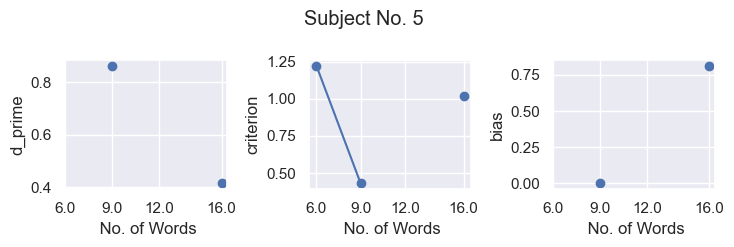

[0.11111111 0.5        0.77777778]


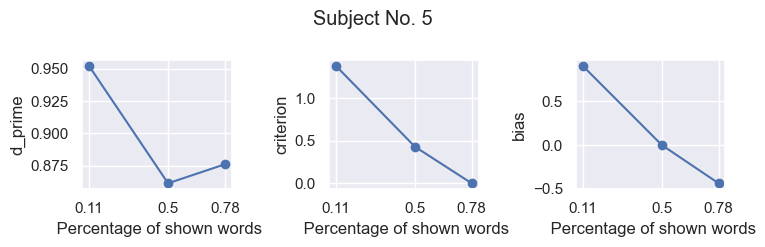

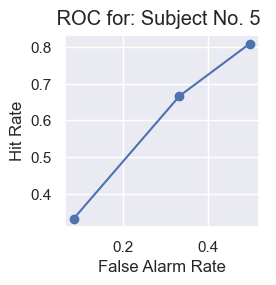

[ 6.  9. 12. 16.]


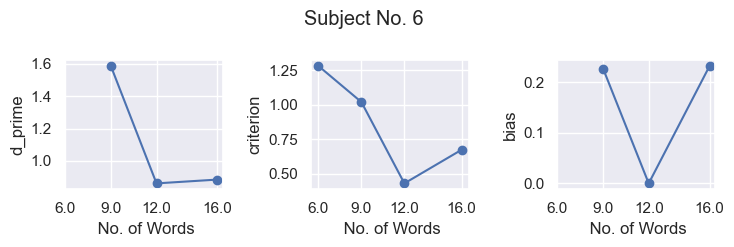

[0.16666667 0.5        0.75      ]


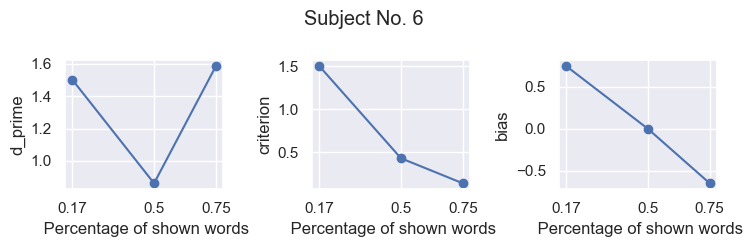

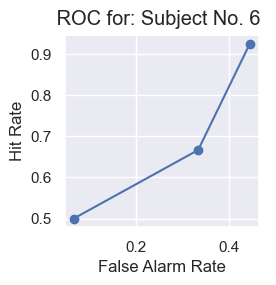

[ 6.  9. 12. 16.]


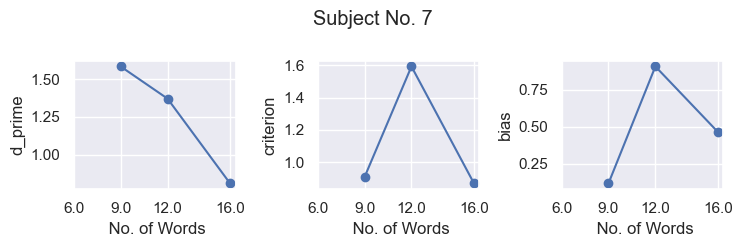

[0.11111111 0.5        0.77777778]


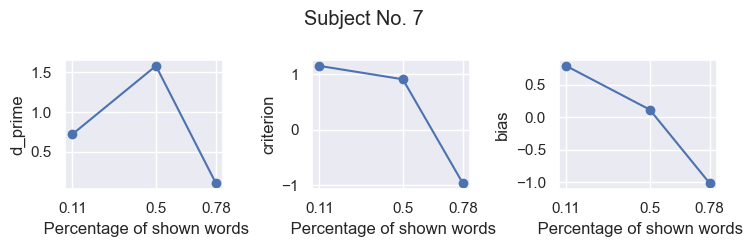

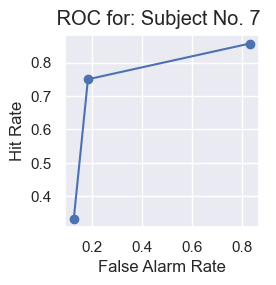

[ 6.  9. 12. 16.]


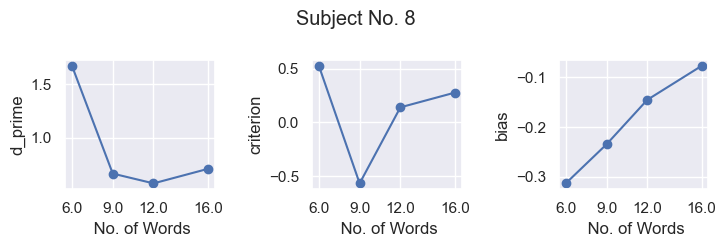

[0.11111111 0.5        0.77777778]


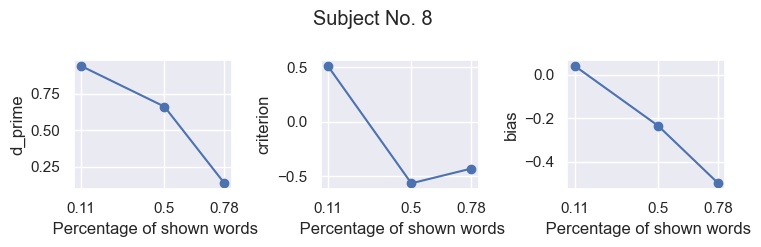

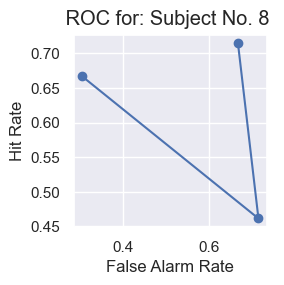

[ 6.  9. 12. 16.]


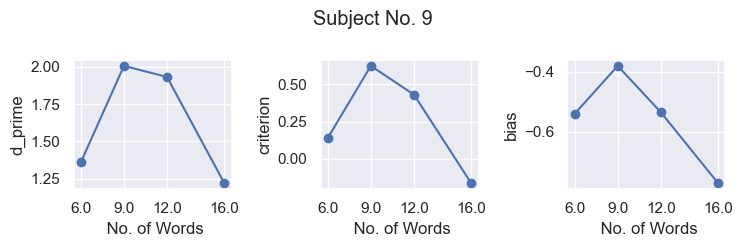

[0.16666667 0.5        0.75      ]


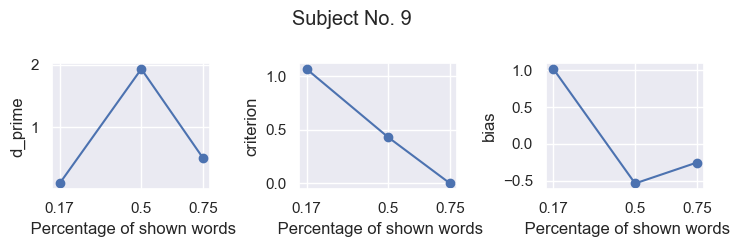

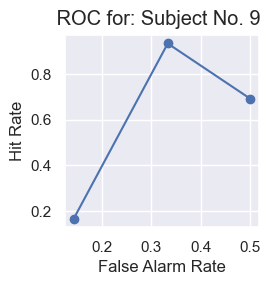

In [210]:

for i in range(len(good_subjects)):
    subject_file_raw_path= os.path.join(RAW_DUMP_FOLDER,"p_"+str(good_subjects[i])+".npz")
    results=np.load(subject_file_raw_path,allow_pickle=True)
    main_results=results["main_results"].astype(float)
    shuffle_results=results["shuffle_results"].astype(float)
    crit_results=results["crit_results"].astype(float)
    process(main_results)
    process(shuffle_results)
    process(crit_results)
    results=np.concatenate([main_results,shuffle_results,crit_results])

    # results are arranged as [Hitrate, Missrate, FalseAlarmrate, CorrectRejectionrate, n_items, perc_recall, shuffle]
    # first we select all the unique n_items and for each n_items we compute the Hitrate and FalseAlarmrate using block_HR_FAR()
    n_items=np.unique(results[:,4])
    print(n_items)
    HR_FAR_n=np.zeros((len(n_items),2))
    d_c_b_n=np.zeros((len(n_items),3))
    for j in range(len(n_items)):
        # we need to select those indices s.t results[:,4]==n_items[j] and perc_recall/n_items belongs to [0.3 0.7] and shuffle==1
        indices=np.where((results[:,4]==n_items[j]) & (results[:,5]==0.5) & (results[:,6]==1))[0]
        HR_FAR_n[j,:]=block_HR_FAR(results[indices,:])
        d_c_b_n[j,:]=d_prime_criterea(HR_FAR_n[j,0],HR_FAR_n[j,1])
    # now we plot the results
    plt_dprime(d_c_b_n,n_items,subject_IDs[i],"_ n items", " No. of Words")
    set_size_d[i,:]=np.abs(d_c_b_n[:,0])
    set_size_b[i,:]=np.abs(d_c_b_n[:,2])
    # now we repeat the same proceedure but for the trials n_item= and for shuffle==0 vs shuffle==1 and perc_recall/n_items belongs to [0.3 0.7]
    HR_FAR_shuffle=np.zeros((2,2))
    d_c_b_shuffle=np.zeros((2,3))
    for j in range(2):
        indices=np.where((results[:,4]==shuffle_results[0][4]) & (results[:,5]==0.5) & (results[:,6]==j))[0]
        HR_FAR_shuffle[j,:]=block_HR_FAR(results[indices,:])
        d_c_b_shuffle[j,:]=d_prime_criterea(HR_FAR_shuffle[j,0],HR_FAR_shuffle[j,1])
    # now we plot the results
    shuffle_d[i,:]=d_c_b_shuffle[:,0]
    #plt_dprime(d_c_b_shuffle,[0,1],subject_IDs[i],"_shuffle", " Shuffled or not shuffled")
    # lastly we have to rpeat the same proceedure but for trials with n_item= and shuffle==1 and varying perc_recall
    indices=np.where((results[:,4]==shuffle_results[0][4])  & (results[:,6]==1))[0]
    perc_recall=np.unique(results[indices,5])
    print(perc_recall)
    HR_FAR_perc=np.zeros((len(perc_recall),2))
    d_c_b_perc=np.zeros((len(perc_recall),3))
    for j in range(len(perc_recall)):
        indices=np.where((results[:,4]==shuffle_results[0][4]) & (results[:,5]==perc_recall[j]) & (results[:,6]==1))[0]
        HR_FAR_perc[j,:]=block_HR_FAR(results[indices,:])
        d_c_b_perc[j,:]=d_prime_criterea(HR_FAR_perc[j,0],HR_FAR_perc[j,1])
    # now we plot the results
    plt_dprime(d_c_b_perc,perc_recall,subject_IDs[i],"_perc_recall"," Percentage of shown words")
    HR_FAR_D_recall[i,:,:2]=HR_FAR_perc
    HR_FAR_D_recall[i,:,2]=d_c_b_perc[:,0]
    HR_FAR_D_recall[i,:,3]=perc_recall

    # now we plot HR vs FAR for  perc and n_items in different colors in the same graph
    fig,ax=plt.subplots(1,1,figsize=(2.5,2.5))
    ax.plot(HR_FAR_perc[:,1],HR_FAR_perc[:,0], 'o-',label="varying criterion")
    ax.set_xlabel("False Alarm Rate")
    ax.set_ylabel("Hit Rate")
    fig.suptitle(" ROC for: Subject No. " + str(subject_IDs[i]) + " " )
    plt.savefig(os.path.join(PLOTS_FOLDER,"p_"+str(subject_IDs[i])+"_HR_FAR.png"))

    plt.show()

average d' shuffled vs not shuffled: 2.665487648803521 +/- 3.2157174642510484


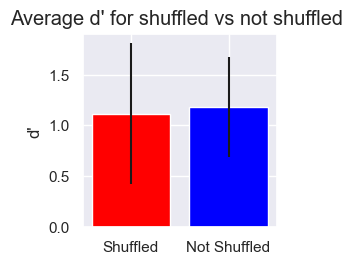

In [211]:
# plot average of d' shuffle as a bar bplot with std as error bars

fig,ax=plt.subplots(1,1,figsize=(2.5,2.5))
ax.bar([0,1],np.mean(shuffle_d,axis=0),yerr=np.std(shuffle_d,axis=0),color=["red","blue"])
ax.set_xticks([0,1])
ax.set_xticklabels(["Shuffled","Not Shuffled"])
ax.set_ylabel("d'")
fig.suptitle("Average d' for shuffled vs not shuffled")
div=shuffle_d[:,1]/shuffle_d[:,0]
print("average d' shuffled vs not shuffled: " + str(np.mean(div)) + " +/- " + str(np.std(div)))



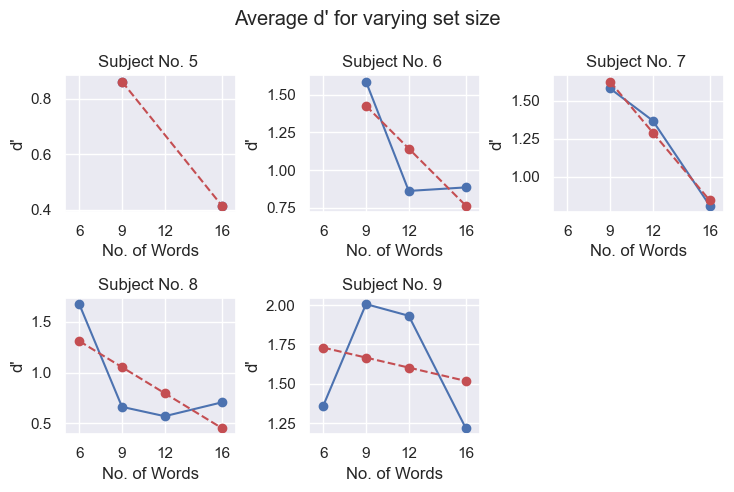

In [212]:
# we plot d' vs n_items for all six subjects, along with a linear trendlines for each subject
sns.set_theme()
fig,ax=plt.subplots(2,3,figsize=(2.5*3,2.5*2))
ax=ax.flatten()
set_size_d[-1,:]=np.nanmean(set_size_d[:-1,:],axis=0)

for i in range(5):
    n_items=np.array([6,9,12,16])
    ax[i].plot(n_items,set_size_d[i,:], 'o-',label="varying set size")
    ax[i].set_xlabel("No. of Words")
    ax[i].set_ylabel("d'")
    ax[i].set_title("Subject No. " + str(subject_IDs[i]) + " " )
    ax[i].set_xticks(n_items)
    ax[i].set_xticklabels(n_items)
    # we fit a linear trendline
    indices= np.isfinite(set_size_d[i,:])

    n_items=n_items[indices]
    z = np.polyfit(n_items, set_size_d[i,indices], 1)
    p = np.poly1d(z)
    ax[i].plot(n_items,p(n_items),"r--o")
    ax[i].set_xlim([5,17])
ax[-1].set_visible(False)
fig.suptitle("Average d' for varying set size")
fig.tight_layout()


C:\Users\curio\AppData\Local\Temp\ipykernel_13808\2712476887.py:26: RuntimeWarning: invalid value encountered in true_divide
  set_size_b1=set_size_b/set_size_d


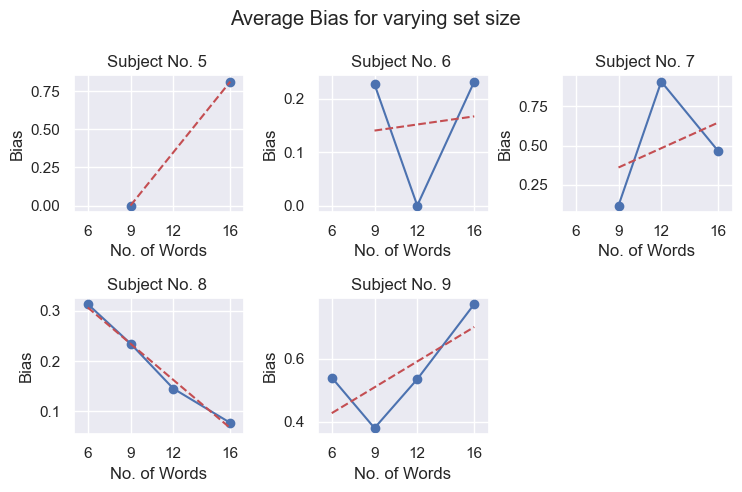

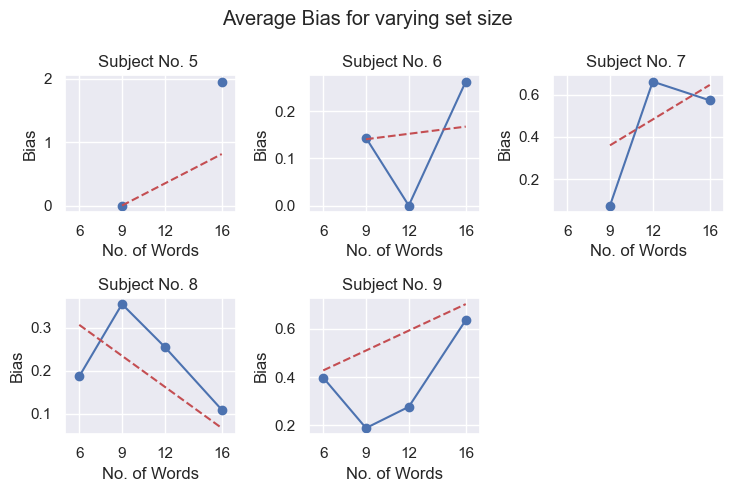

In [213]:
# we now plot bias vs n_items for all six subjects, along with a linear trendlines for each subject
sns.set_theme()
fig,ax=plt.subplots(2,3,figsize=(2.5*3,2.5*2))
ax=ax.flatten()
set_size_b[-1,:]=np.nanmean(set_size_b[:-1,:],axis=0)
for i in range(5):
    n_items=np.array([6,9,12,16])
    ax[i].plot(n_items,set_size_b[i,:], 'o-',label="varying set size")
    ax[i].set_xlabel("No. of Words")
    ax[i].set_ylabel("Bias")
    ax[i].set_title("Subject No. " + str(subject_IDs[i]) + " " )
    ax[i].set_xticks(n_items)
    ax[i].set_xticklabels(n_items)
    # we fit a linear trendline
    indices= np.isfinite(set_size_b[i,:])
    n_items=n_items[indices]
    z = np.polyfit(n_items, set_size_b[i,indices], 1)
    p = np.poly1d(z)
    ax[i].plot(n_items,p(n_items),"r--")
    ax[i].set_xlim([5,17])
fig.suptitle("Average Bias for varying set size")
ax[-1].set_visible(False)
fig.tight_layout()

# we now plot bias vs n_items for all six subjects, along with a linear trendlines for each subject
set_size_b1=set_size_b/set_size_d
set_size_b1[-1,:]=np.nanmean(set_size_b1[:-1,:],axis=0)
fig,ax=plt.subplots(2,3,figsize=(2.5*3,2.5*2))
ax=ax.flatten()
set_size_b[-1,:]=np.nanmean(set_size_b[:-1,:],axis=0)
for i in range(5):
    n_items=np.array([6,9,12,16])
    ax[i].plot(n_items,set_size_b1[i,:], 'o-',label="varying set size")
    ax[i].set_xlabel("No. of Words")
    ax[i].set_ylabel("Bias")
    ax[i].set_title("Subject No. " + str(subject_IDs[i]) + " " )
    ax[i].set_xticks(n_items)
    ax[i].set_xticklabels(n_items)
    # we fit a linear trendline
    indices= np.isfinite(set_size_b1[i,:])
    n_items=n_items[indices]
    z = np.polyfit(n_items, set_size_b[i,indices], 1)
    p = np.poly1d(z)
    ax[i].plot(n_items,p(n_items),"r--")
    ax[i].set_xlim([5,17])
fig.suptitle("Average Bias for varying set size")
ax[-1].set_visible(False)
fig.tight_layout()


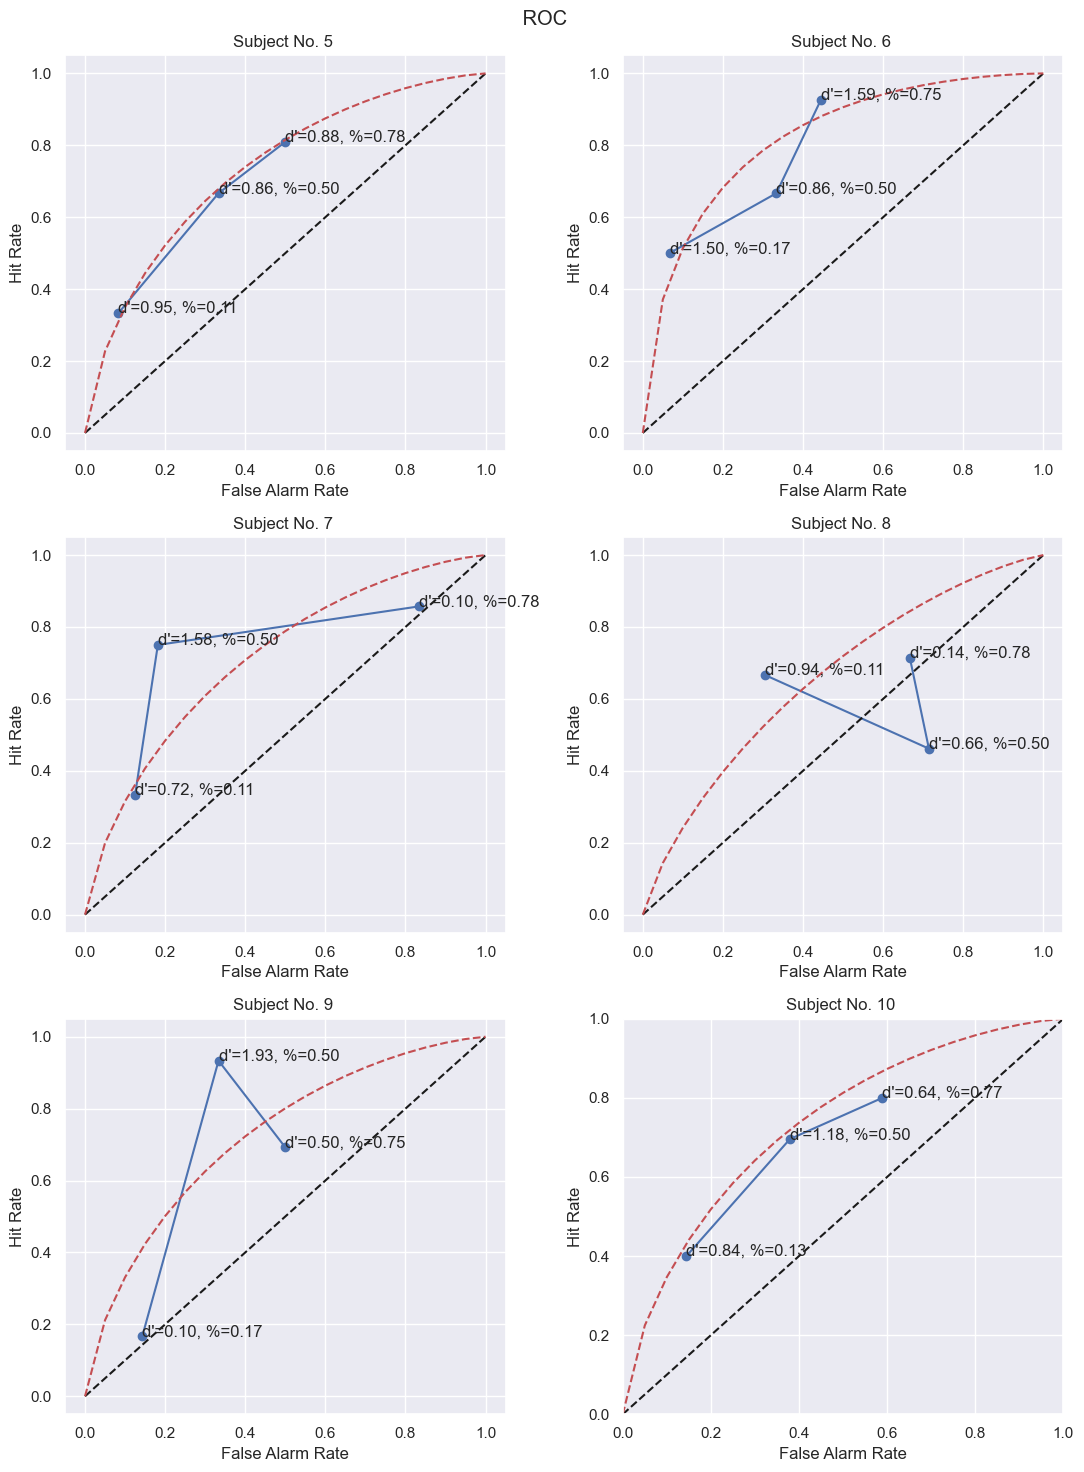

In [217]:
HR_FAR_D_recall[-1,:,:]=np.nanmean(HR_FAR_D_recall[:-1,:,:],axis=0)
FA_list=np.arange(0,1.1,0.05)
# we plot HR vs FAR for all subjects, and we add labels of d' and perc recall
fig,ax=plt.subplots(3,2,figsize=(5.5*2,5*3))
ax=ax.flatten()
def get_HR(FA,D):
    H=np.zeros(FA.shape)
    for i in range(FA.shape[0]):
        H[i]=stats.norm.cdf(D+stats.norm.ppf(FA[i]))
    return H
for i in range(len(ax)):
    ax[i].plot(HR_FAR_D_recall[i,:,1],HR_FAR_D_recall[i,:,0], 'o-',label="varying criterion")
    ax[i].set_xlabel("False Alarm Rate")
    ax[i].set_ylabel("Hit Rate")
    ax[i].set_title("Subject No. " + str(subject_IDs[i]) + " " )
    plt.xlim([0,1])
    plt.ylim([0,1])

    # each point is labeled with d' and perc recall
    # lets also plot a diagonal line
    ax[i].plot([0,1],[0,1],'k--')

    # lets also plot the ROC curve for the average d' value
    avg_d=np.nanmean(HR_FAR_D_recall[i,:,2])
    HR_ideal=get_HR(FA_list,avg_d)
    ax[i].plot(FA_list,HR_ideal,'r--')

    for j in range(len(HR_FAR_D_recall[i,:,1])):
        text=f"d'={HR_FAR_D_recall[i,j,2]:.2f}, %={HR_FAR_D_recall[i,j,3]:.2f}"
        ax[i].annotate(text,(HR_FAR_D_recall[i,j,1],HR_FAR_D_recall[i,j,0]))
fig.suptitle(" ROC")
fig.tight_layout()

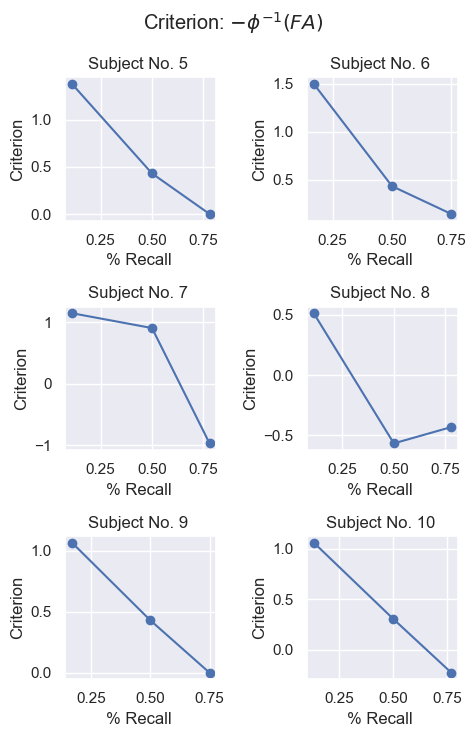

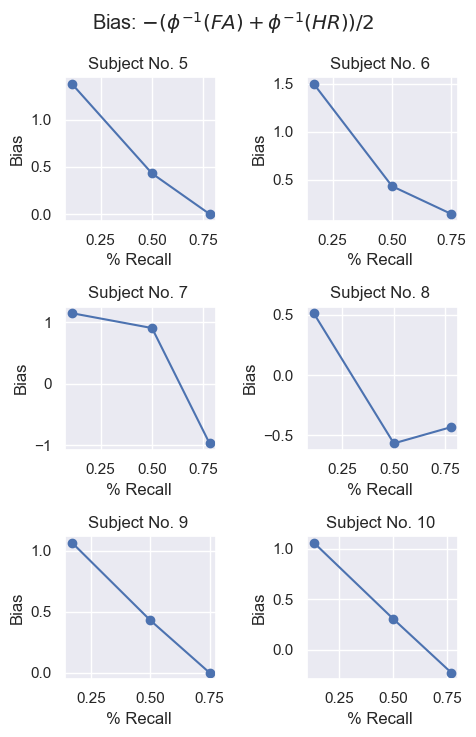

In [215]:

# we plot HR vs FAR for all subjects, and we add labels of d' and perc recall
fig,ax=plt.subplots(3,2,figsize=(2.5*2,2.5*3))
ax=ax.flatten()
for i in range(len(ax)):
    ax[i].plot(HR_FAR_D_recall[i,:,3],-stats.norm.ppf (HR_FAR_D_recall[i,:,1]), 'o-',label="varying criterion")
    ax[i].set_xlabel("% Recall ")
    ax[i].set_ylabel("Criterion")
    ax[i].set_title("Subject No. " + str(subject_IDs[i]) + " " )
    # each point is labeled with d' and perc recall
fig.suptitle("Criterion: $-{\phi}^{-1}(FA)$")
fig.tight_layout()

fig,ax=plt.subplots(3,2,figsize=(2.5*2,2.5*3))
ax=ax.flatten()
for i in range(len(ax)):
    ax[i].plot(HR_FAR_D_recall[i,:,3],-(stats.norm.ppf (HR_FAR_D_recall[i,:,1])+stats.norm.ppf (HR_FAR_D_recall[i,:,1]))/2, 'o-',label="varying criterion")
    ax[i].set_xlabel("% Recall ")
    ax[i].set_ylabel("Bias")
    ax[i].set_title("Subject No. " + str(subject_IDs[i]) + " " )
    # each point is labeled with d' and perc recall
fig.suptitle("Bias: $-({\phi}^{-1}(FA)+{\phi}^{-1}(HR))/2}$")
fig.tight_layout()



In [216]:
H=stats.norm.cdf(2*0.+stats.norm.ppf(0.5))
print(H)

0.5
